# Cleaned up API call for cryptodata
This file is a cleaned up version of a previous jupyter notebook in which readability of the code is preferred. 

In [15]:
from datetime import timedelta, date, timezone
from datetime import datetime as dt
import json
from matplotlib import style
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import requests
from collections import OrderedDict, Counter
import matplotlib.dates as mdates

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
style.use('ggplot')

INTERVAL = 2000*60
COINS = ['ARK', 'BTC', 'BCC', 'DASH','DOGE', 'ETH','ETC' 'EXP', 'KMD','LTC',
        'NEO', 'PIVX', 'POSW', 'XLM', 'STRAT','UBQ', 'VTC', 'XRP', 'VIA', 'ZCASH']
#COINS = ['ETH', 'BTC']

Populating the interactive namespace from numpy and matplotlib


In [2]:
def conv_date(inp):
    return int(inp.replace(tzinfo=timezone.utc).timestamp())

def dates(start, end, i):
    
    
    #TO DO: REPLACE WITH A RANGE FUNCTION
    start = dt.strptime(start, "%d/%m/%Y %H:%M")
    end = dt.strptime(end, "%d/%m/%Y %H:%M")
    results = []
    
    while start < end:
        results.append(start)
        start += timedelta(minutes=i)
        
    #add the current date, because the CC-API uses this to get the most recent prices.
    results.append(end)
    return results

In [3]:
def coin_startdates(COINS, reload=False):
    """
    Returns a list of pairs with a coin_name and its starting date
    """
    coin_data = []
    if reload:
        html = 'https://www.cryptocompare.com/api/data/coinlist/'
        resp = requests.get(html)
        coin = (resp.json())
        for c in list(coin['Data']):
            if COINS and c not in COINS:
                continue
            coinid = coin['Data'][c]['Id']
            start_html = 'https://www.cryptocompare.com/api/data/coinsnapshotfullbyid/?id={}'.format(coinid)
            response = requests.get(start_html).json()
            coinsnapshotfullID = response['Data']['General']
            coin_data.append([c, coinsnapshotfullID])
            
        with open('coin_data.md', 'wb') as f:
            pickle.dump(coin_data, f)
            
    else:
        with open('coin_data.md' ,'rb') as f:
            coin_data = pickle.load(f)
    
    if COINS:
        coin_data = [c for c in coin_data if c[0] in COINS]
        
    coin_data = dict([(c[0], c[1]['StartDate']+ ' 0:00',) 
                 for c in coin_data if c[1]['StartDate'] != '01/01/0001'])
    return coin_data

coins = coin_startdates(COINS, reload=True)
print(coins)

{'BTC': '03/01/2009 0:00', 'LTC': '13/10/2011 0:00', 'DASH': '18/01/2014 0:00', 'DOGE': '06/12/2013 0:00', 'XRP': '02/02/2013 0:00', 'XLM': '19/07/2013 0:00', 'VIA': '18/07/2014 0:00', 'STRAT': '09/08/2016 0:00', 'KMD': '01/09/2016 0:00', 'POSW': '01/12/2016 0:00', 'PIVX': '25/11/2015 0:00', 'UBQ': '29/09/2016 0:00', 'ETH': '30/07/2015 0:00', 'VTC': '08/01/2014 0:00'}


In [30]:
def C_USD(cdate, coin_name, reload=False):
    if not reload and 'BTC-USD.md' in os.listdir():
        dframes = [pd.read_pickle('{}-USD.md'.format(coin_name))]
        date = dates(dframes[0].tail(1).index[0], 
                     dt.now().strftime('%d/%m/%Y %H:%M'), 
                     INTERVAL)
    else:

        dframes = []
        date = dates(cdate, 
                     dt.now().strftime('%d/%m/%Y %H:%M'), 
                     INTERVAL)
    for d in date:
        USD_html = 'https://min-api.cryptocompare.com/data/histohour?aggregate=1&extraParams=CryptoCompare&fsym={}&limit=2000&tryConversion=false&tsym=USD&toTs={}'.format(coin_name, conv_date(d))
        response = requests.get(USD_html).json()
        for n, x in enumerate(response['Data']):
            response['Data'][n]['time'] = dt.fromtimestamp(response['Data'][n]['time']).strftime('%d/%m/%Y %H:%M')
        if response['Data'] != []:
            df = pd.DataFrame(response['Data'])

            df = df.set_index('time')
            
            dframes.append(df)
    
    if len(dframes) > 0:
        result = pd.concat(dframes)
        result = result[~result.index.duplicated(keep='last')]
        result.to_pickle('{}-USD.md'.format(coin_name))
    else:
        print('coin needs to be done by using BTC as a benchmark for price')
        result = []
    return result

results = {}
results['BTC'] = C_USD(coins['BTC'], 'BTC', reload=False)
print(results['BTC'].tail())


                     close      high       low      open  volumefrom  \
time                                                                   
13/01/2018 16:00  14301.29  14445.46  14210.58  14432.38     3855.98   
13/01/2018 17:00  14315.16  14422.18  14301.29  14301.29     2791.27   
13/01/2018 18:00  14351.63  14363.51  14262.01  14315.97     2649.41   
13/01/2018 19:00  14317.86  14393.14  14299.84  14351.63     2371.52   
13/01/2018 20:00  14341.56  14351.75  14313.52  14317.86      617.32   

                     volumeto  
time                           
13/01/2018 16:00  55450077.76  
13/01/2018 17:00  40319174.04  
13/01/2018 18:00  38063761.39  
13/01/2018 19:00  34165420.48  
13/01/2018 20:00   8896823.03  


Now that we have BTC, get all other coins. If they don't have a USD - convert with BTC value (close). This is an approximation obviously. 

In [5]:
def C_BTC_USD(cdate, coin_name, BTC, reload=False):
    if reload:
        dframes = []
        date = dates(cdate, 
                     dt.now().strftime('%d/%m/%Y %H:%M'), 
                     INTERVAL)
    else:
        dframes = [pd.read_pickle('{}-USD.md'.format(coin_name))]
        date = dates(dframes[0].tail(1).index[0], 
                     dt.now().strftime('%d/%m/%Y %H:%M'), 
                     INTERVAL)
        
    for d in date:
        BTC_html = 'https://min-api.cryptocompare.com/data/histohour?aggregate=1&extraParams=CryptoCompare&fsym={}&limit=2000&tryConversion=false&tsym=BTC&toTs={}'.format(coin_name, conv_date(d))
        response = requests.get(BTC_html).json()
        for n, x in enumerate(response['Data']):
            response['Data'][n]['time'] = dt.fromtimestamp(response['Data'][n]['time']).strftime('%d/%m/%Y %H:%M')
        if response['Data'] != []:
            df = pd.DataFrame(response['Data'])
            df = df.set_index('time')
            dframes.append(df)
    
    if len(dframes) > 0:
        result = pd.concat(dframes)
        result = result[~result.index.duplicated(keep='last')]
        result['close'] = result['close'] * BTC['close']
        result['high'] = result['high'] * BTC['close']
        result['low'] = result['low'] * BTC['close']
        result['open'] = result['open'] * BTC['close']
        result.to_pickle('{}-USD.md'.format(coin_name))
        
    return result
            
def all_coins(results, coins, full_reset=False):
    coins = {c:v for c,v in coins.items() if c != 'BTC'}
    for coin in coins:
        print(coin)
        if '{}-USD.md'.format(coin) in os.listdir() and full_reset==False:
            results[coin] = C_USD(coins[coin], coin, reload=False)
        else:
            results[coin] = C_USD(coins[coin], coin, reload=True)
    
    
    for coin,v in results.items():
        if len(v) == 0:
            print('{} is going to be converted to BTC first'.format(coin))
            if '{}-USD.md'.format(coin) in os.listdir() and full_reset==False:
                result[coin] = C_BTC_USD(coins[coin], coin, results['BTC'], reload=False)
            else:
                results[coin] = C_BTC_USD(coins[coin], coin, results['BTC'], reload=True)            
    
    return results


results = all_coins(results, coins)
print(results.keys())

LTC
DASH
DOGE
XRP
XLM
VIA
STRAT
KMD
POSW
PIVX
UBQ
ETH
VTC
dict_keys(['BTC', 'LTC', 'DASH', 'DOGE', 'XRP', 'XLM', 'VIA', 'STRAT', 'KMD', 'POSW', 'PIVX', 'UBQ', 'ETH', 'VTC'])


Random trial to see if you can get moving averages (yes, over X periods) and procentual gains (yes, with pct_change). This way, we can establish when a rolling average becomes negative.

                  close   high    low   open  volumefrom  volumeto
time                                                              
11/02/2013 01:00  23.97  23.97  23.97  23.97         0.0       0.0
11/02/2013 02:00  23.97  23.97  23.97  23.97         0.0       0.0
11/02/2013 03:00  23.97  23.97  23.97  23.97         0.0       0.0
11/02/2013 04:00  23.97  23.97  23.97  23.97         0.0       0.0
11/02/2013 05:00  23.97  23.97  23.97  23.97         0.0       0.0


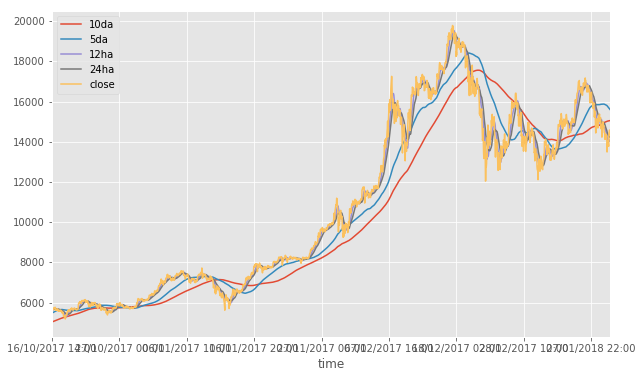

time
10/01/2018 16:00    15670.059083
10/01/2018 17:00    15654.850167
10/01/2018 18:00    15639.564083
10/01/2018 19:00    15623.812583
10/01/2018 20:00    15606.147167
Name: 5da, dtype: float64
time
10/01/2018 16:00   -0.000875
10/01/2018 17:00   -0.000971
10/01/2018 18:00   -0.000976
10/01/2018 19:00   -0.001007
10/01/2018 20:00   -0.001131
Name: 5dapr, dtype: float64


In [52]:
def tmp(results):
    results = results['BTC']
    results['10da'] = results['close'].rolling(window=24*10, min_periods=0).mean()
    results['5da'] = results['close'].rolling(window=24*5, min_periods=0).mean()
    results['12ha'] = results['close'].rolling(window=12, min_periods=0).mean()
    results['24ha'] = results['close'].rolling(window=24, min_periods=0).mean()
    results['5dapr'] = results['5da'] .pct_change()
    results[['10da','5da', '12ha', '24ha', 'close']][41000:56000].plot()
    plt.show()
    print(results['5da'].tail())
    print(results['5dapr'].tail())
    
tmp(results)


In [51]:
def rolling(pd, row, periods, min_periods=100):
    rol = pd[row].rolling(window=periods, min_periods=min_periods).mean() 
    return rol, rol.pct_change()

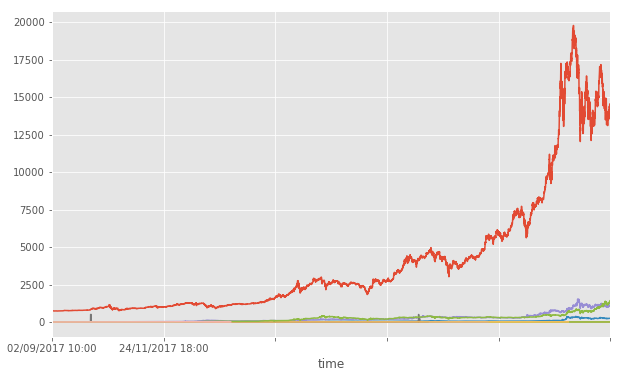

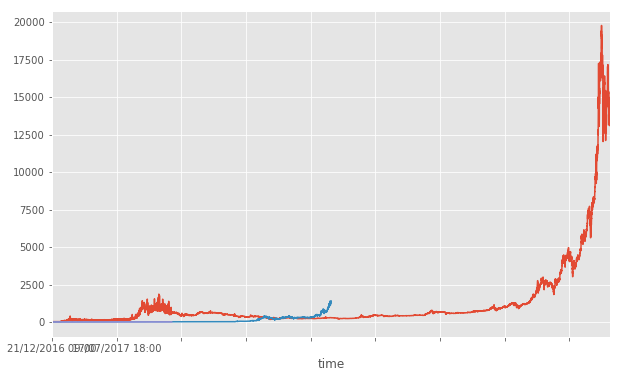

In [7]:
def plotcoins(results):
    for coin in results:
        results[coin].index =             df['time'] = pd.to_datetime(df['time'])
            results[coin].index = df['time'].map(mdates.date2num)
        results[coin]['close'][-10000:-1].plot()
    plt.show()
    
plotcoins(results)
            #df['time'] = pd.to_datetime(df['time'])
            #df['time'] = df['time'].map(mdates.date2num)
results['BTC']['close'].plot()
results['ETH']['close'].plot()
results['UBQ']['close'].plot()